In [1]:
import random
import buildNetwork
import basicRunDORA
import pdb
import numpy as np
import seaborn as sns
NUM_ANALOGS = 4
N_COMPONENTS = 10
PER_ANALOG = 5
REPETITIONS = 1

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [68]:
parameters = {'asDORA': True, 'gamma': 0.3,
              'delta': 0.05, 'eta': 0.9,
              'HebbBias': 0.5,
              'bias_retrieval_analogs': False, 'use_relative_act': False, # Changeeeeddd!!!!!!!!
              #'run_order': ['cdr', 'selectTokens', 'r', 'wp', 'm', 'p', 's', 'f', 'c'],
              'run_order': ['cdr', 'selectTokens', 'r', 'm','c'],
              'run_cyles': 100, 'write_on_iteration': 100, 'firingOrderRule': 'in_order',
              'dim_list':[],
              'strategic_mapping': True, 'ignore_object_semantics': False,
              'ignore_memory_semantics': True, 'mag_decimal_precision': 0,
              'exemplar_memory': False, 'recent_analog_bias': True,
              'lateral_input_level': 1, 'screen_width': 1200, 'screen_height': 700,
              'doGUI': False, 'testing': True, 'GUI_update_rate': 50, 'starting_iteration': 0,
              'tokenize': False, 'ho_sem_act_flow': 0, 'remove_uncompressed': False, 'remove_compressed': False,
              'num_choose':10,'one_to_one':True,'max_norm':True, 'filename':'karthikeya/test_sim_custom-WordGCN-7-empty_pred.py',
             'len_regularisation':1, 'count_by_RBs':False, 'parent_bias':0.1, 'order_activation_bias':0.5,
             'results':'karthikeya/data/results/WordGCN.pkl',
             'activation_storage_path':'karthikeya/data/results/activations/'}

In [3]:
def init_network(parameters):
    reload(buildNetwork)
    reload(basicRunDORA)
    fileName = parameters['filename']
    f = open(fileName, 'r')
    simType = ''
    d = {'simType': simType}
    f.seek(0)
    exec (f.readline())
    if simType == 'sym_file':
        symstring = ''
        for line in f:
            symstring += line
        exec(symstring)
    # initialise memory
    memory = buildNetwork.initializeMemorySet()
    # interpret sym file
    mysym = buildNetwork.interpretSymfile(symProps)
    # build the network
    memory = basicRunDORA.dataTypes.memorySet()
    memory = buildNetwork.buildTheNetwork(mysym[0], memory)
    network = basicRunDORA.runDORA(memory, parameters)
    memory = basicRunDORA.update_memory_with_levels(memory)
    # run cycles
    # initialise mapping adjacency matrix:
    mapping_adj = np.zeros((len(network.memory.Ps), len(network.memory.Ps)))
    return [network, memory, mapping_adj]

In [4]:
def vis_mappings(mapping_mat, prop_names):
    sns_heatmap = sns.heatmap(mapping_mat, linewidth=0.5,xticklabels=prop_names, yticklabels=prop_names)
    fig = sns_heatmap.get_figure()
    return

In [5]:
def mapping_error(mapping_mat):
    # assuming an even split - NUM_ANALOGS * PER_ANALOG = number of analogs, number of propositions per analog
    # the mapping matrix is ordered by propositions, therefore every n%PER_ANALOG should be mapped together.
    # the mapping_mat is L1 normalised, and so the target matrix should contain values = 1.0/(NUM_ANALOGS - 1)
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1.0/(NUM_ANALOGS - 1)
    mapping_mat = mapping_mat * (target_mat > 0) # keep only diagonals for comparisons
    error_mat = (mapping_mat - target_mat)**2
    error_val = np.sqrt(np.mean(error_mat))
    return error_val

In [6]:
def get_metrics(mapping_mat):
    # mapping_mat contains the predicted mappings
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1
    # target_mat contains the true mappings in boolean values
    # Get True Positives (TP)
    true_positives = sum(sum(mapping_mat * target_mat))
    # False Positives (FP) 
    false_positives =  sum(np.sum(mapping_mat * abs(target_mat-1), axis=0))# gives all those non-zero mappings at the wrong place.
    # False Negatives (FN) giving zero mapping when it should actually be non zero
    false_negatives = sum(np.sum(mapping_mat * abs(target_mat-1), axis=1)) 
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(true_positives + false_negatives) 
    f_score = (2 * precision * recall) / (precision + recall)
    rmse = mapping_error(mapping_mat)
    return precision, recall, f_score, rmse

In [ ]:
# networ, memory, mapping_adj = init_network()
for cycle in range(parameters['run_cyles']):
    print('\n\n************************* Cycle: ' + str(cycle+1))

    # clear driver and recipient
    network.memory = basicRunDORA.clearDriverSet(network.memory)
    network.memory = basicRunDORA.clearRecipientSet(network.memory)

    # put the randomly chosen proposition in the driver
    proposition = random.sample(network.memory.Ps,k=parameters['num_choose']) # currently three propositions
    if parameters['num_choose'] > 1:
        proposition_num = []
        for p in proposition:
            proposition_num.append(network.memory.Ps.index(p))
    else:
        proposition_num = network.memory.Ps.index(proposition)

    if parameters['num_choose'] > 1:
        for p_num in proposition_num:
            network.memory = basicRunDORA.add_tokens_to_set(network.memory, p_num, 'P', 'driver')
    else:
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, proposition_num, 'P', 'driver')



    # make sure the driver and the recipient are set
    network.memory = basicRunDORA.findDriverRecipient(network.memory)
    network.do_map()

    # display ALL mappings
    #pdb.set_trace()
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            map_weight = mapping.weight
            if map_weight > 0:
                map_unit = mapping.recipientToken
                if mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] < 0.1:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
                else:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = (map_weight + 
                        mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)])/2.0 # DIRTY SOLUTION FOR NOW
            #print str(network.memory.Ps.index(myP)) + str(' -- ') + str(network.memory.Ps.index(map_unit)) + str(' : ') + str(map_weight)
    # display mappings
    print('\n\nMappings:\n')
    basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

In [7]:
def print_map_connections(network):
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            print myP.name, mapping.recipientToken.name, mapping.weight

In [20]:
def get_coactivations(network,store_iteration):
    array_PO, array_RB, array_P = basicRunDORA.init_store_activations(network.memory)
    for analog in network.memory.analogs:
        network.memory = basicRunDORA.clearDriverSet(network.memory) # clear driver
        network.memory = basicRunDORA.clearRecipientSet(network.memory) # clear recipient
        analog_num = network.memory.analogs.index(analog) # set analog number
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, analog_num, 'analog', 'driver') # put analog into driver
        # retrieve analogs similar to one in the driver from LTM
        network.memory = basicRunDORA.findDriverRecipient(network.memory) # load up the memory
        array_PO,array_RB,array_P = network.do_retrieval(store_activations=True,store_iteration=store_iteration,
                                                         array_PO=array_PO,array_RB=array_RB,array_P=array_P) 
        network.memory = basicRunDORA.findDriverRecipient(network.memory)
    network.write_all_activations(store_iteration,array_PO,array_RB,array_P)
    return network
    

In [67]:
temp = np.array([1,2,3,4])
np.savetxt(parameters['activation_storage_path']+'PO_'+'None'+'.csv', temp)

In [69]:
simulated_data = {}
for repetition in range(REPETITIONS):
    network, memory, mapping_adj = init_network(parameters)
    precisions, recalls, fscores, rmses = [],[],[],[]
    for cycle in range(parameters['run_cyles']):
        if (cycle+1)%10 == 0:
            network = get_coactivations(network,cycle+1)
        print('\n\n************************* Cycle: ' + str(cycle+1))
        #pdb.set_trace()
        # clear driver and recipient
        network.memory = basicRunDORA.clearDriverSet(network.memory)
        network.memory = basicRunDORA.clearRecipientSet(network.memory)
        # choose random analog from memory
        analog = random.choice(network.memory.analogs) # currently only one analog
        # choose random propositions from memory

        # put the analog in the driver
        analog_num = network.memory.analogs.index(analog)
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, analog_num, 'analog', 'driver')
        # retrieve analogs similar to one in the driver from LTM
        network.memory = basicRunDORA.findDriverRecipient(network.memory)
        network.do_retrieval()
        network.memory = basicRunDORA.findDriverRecipient(network.memory)

        #print('In driver : ' + network.memory.driver.Ps[0].name[1])
        #if len(network.memory.recipient.Ps) > 0:
        #    print('In recipient : ' + network.memory.recipient.Ps[0].name[1])
        #    if network.memory.recipient.Ps[0].name[1] == '3':
        #        network.do_map()
        #        print('\n\nMappings:\n')
        #        basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

        if len(network.memory.recipient.Ps) > 0: 
            print 'retrieval successful'
            # map the analogs in driver and recipient
            network.do_map()
            # display ALL mappings
            # display mappings
            print('\n\nMappings:\n')
            basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=False, only_max=False)
            # store all mappings : 
            for myP in network.memory.driver.Ps:
                for mapping in myP.mappingConnections:
                    map_weight = mapping.weight
                    map_unit = mapping.recipientToken
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
        # append rmse to list to keep track of RMSE evolution
        temp_mapping_adj  = mapping_adj
        for ind in range(temp_mapping_adj.shape[0]):
            if sum(temp_mapping_adj[ind,:]) > 0:
                temp_mapping_adj[ind,:] = temp_mapping_adj[ind,:]/sum(temp_mapping_adj[ind,:])    
        prec,rec,fsc,rmse = get_metrics(temp_mapping_adj)
        precisions.append(prec)
        recalls.append(rec)
        fscores.append(fsc)
        rmses.append(rmse)

    # normalise mappings
    for ind in range(mapping_adj.shape[0]):
        if sum(mapping_adj[ind,:]) > 0:
            mapping_adj[ind,:] = mapping_adj[ind,:]/sum(mapping_adj[ind,:])
    simulated_data[repetition] = [fscores,rmses,mapping_adj]



************************* Cycle: 1
retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- NONE -- mapping_weight=', 0.0)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- NONE -- mapping_weight=', 0.0)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.07247872945138216)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB: detdeer -- NONE -- mapping_weight=

C:\Users\karkau\AppData\Local\Continuum\anaconda2\envs\Dora\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.10365468703224852)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P00 -- mapping_weight=', 0.17314638464875898)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- P27 -- mapping_weight=', 0.16397319064227828)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.0033760442224745097)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P04 -- mapping_weight=', 0.36473305364014486)
('RB: detlions -- detdogs -- mapping_weight=', 0.0001037709115804475)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- hungrydogs -- mapping_weight=', 0.1578756601575

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P25.2 -- P25.2 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.606262591251465)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P27 -- mapping_weight=', 0.16397319064227828)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P32 -- P00 -- mapping_weight=', 0.18617729756394258)
('P: P33.1 -- NONE -- mapping_weight=', 0.0)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P25.1 -- mapping_weight=', 0.38900219111977613)
('P: P34 -- P25 -- mapping_weight=', 1)
('P: P35.1 -- P17.1 -- mapping_weight=', 0.03979289787595881)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P25.2 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P37 -- P37 -- mapping_weight=', 0.48975796846436104)
('RB: detsnakes -- detdogs -- mapping_weight=', 0.0021783439154514496)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mapping_weight=', 0.9775328428667107)
('RB: h

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.10365468703224852)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P04.1 -- mapping_weight=', 0.35258471569274263)
('P: P14 -- P34 -- mapping_weight=', 0.8001464945511932)
('P: P15.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.6866757530682323)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P17 -- P04 -- mapping_weight=', 0.36473305364014486)
('RB: detlions -- juicyrats -- mapping_weight=', 0.04032581021921481)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- hun

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.18617729756394258)
('P: P01 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P02 -- P02 -- mapping_weight=', 0.10365468703224852)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P04 -- P04 -- mapping_weight=', 0.8907647211905323)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.7772521328200434)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- detdogs -- mapping_weight=', 0.0021783439154514496)
('RB: chasecats -- chasecats -- mapping_weight=', 0.45467843422177706)
('RB: hungrydogs -

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.2308308112810521)
('P: P01 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P02 -- P02 -- mapping_weight=', 0.10365468703224852)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P04 -- P04 -- mapping_weight=', 0.8907647211905323)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.7772521328200434)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- baldeagles -- mapping_weight=', 0.024184118163767573)
('RB: chasecats -- chasecats -- mapping_weight=', 0.45467843422177706)
('RB: hungrydogs 

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P31 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P32 -- P00 -- mapping_weight=', 0.18617729756394258)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8736758223040793)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P25.1 -- mapping_weight=', 0.38900219111977613)
('P: P34 -- P25 -- mapping_weight=', 1)
('P: P35.1 -- P17.1 -- mapping_weight=', 0.03979289787595881)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P25.2 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.7772521328200434)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P37 -- P37 -- mapping_weight=', 0.48975796846436104)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9155090469847506)
('RB: eatrats -- eatrats -- mapping_weight=', 0.3193330306629607)
('RB: angrysnakes --

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P21 -- P01 -- mapping_weight=', 0.07077002845470831)
('P: P22 -- P22 -- mapping_weight=', 0.2308308112810521)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.7909295562915778)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P24 -- P34 -- mapping_weight=', 0.8003874320700731)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P25.2 -- P25.2 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.606262591251465)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.34828054309376166)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P27 -- P27 -- mapping_weight=', 0.6679161152638383)
('RB: deteagles -- angrysnakes -- mapping_weight=', 0.03724299924384324)
('RB: eatworms -- biglions -- mapping_weight=', 0.13504473143509524)
('RB: m



************************* Cycle: 30
retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P21 -- P01 -- mapping_weight=', 0.07077002845470831)
('P: P22 -- P22 -- mapping_weight=', 0.2308308112810521)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.7909295562915778)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P24 -- P34 -- mapping_weight=', 0.8003874320700731)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P25.2 -- P25.2 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.606262591251465)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.34828054309376166)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P27 -- P27 -- mapping_weight=', 0.6679161152638383)
('RB: deteagles -- angrysnakes -- mapping_weight=', 0.03724299924384324)
('RB: eatworms -- biglions -- mapping_

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P31 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P32 -- P32 -- mapping_weight=', 0.18637320291346404)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8736758223040793)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P25.1 -- mapping_weight=', 0.38900219111977613)
('P: P34 -- P25 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.17960936924343873)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P25.2 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.7772521328200434)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P37 -- P37 -- mapping_weight=', 0.48975796846436104)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9155090469847506)
('RB: eatrats -- eatrats -- mapping_weight=', 0.3193330306629607)
('RB: angrysnakes -- an

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P04.1 -- mapping_weight=', 0.35258471569274263)
('P: P14 -- P34 -- mapping_weight=', 0.8001464945511932)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.2281676216040023)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.6866757530682323)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P17 -- P04 -- mapping_weight=', 0.36473305364014486)
('RB: detlions -- fluffycats -- mapping_weight=', 0.06846514206907856)
('RB: huntdeer -- detdogs -- mapping_weight=', 0.015371725347423176)
('RB

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P04.1 -- mapping_weight=', 0.35258471569274263)
('P: P14 -- P34 -- mapping_weight=', 0.8001464945511932)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.2281676216040023)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.6866757530682323)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P17 -- P04 -- mapping_weight=', 0.36473305364014486)
('RB: detlions -- fluffycats -- mapping_weight=', 0.06846514206907856)
('RB: huntdeer -- detdogs -- mapping_weight=', 0.015371725347423176)
('RB

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P04.1 -- mapping_weight=', 0.35258471569274263)
('P: P14 -- P34 -- mapping_weight=', 0.8001464945511932)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.2281676216040023)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.6866757530682323)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P17 -- P04 -- mapping_weight=', 0.36473305364014486)
('RB: detlions -- eatrats -- mapping_weight=', 0.07218096012574018)
('RB: huntdeer -- detdogs -- mapping_weight=', 0.015371725347423176)
('RB: a

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P01 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P02 -- P02 -- mapping_weight=', 0.10365468703224852)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P04 -- P04 -- mapping_weight=', 0.8907647211905323)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.7772521328200434)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P07 -- P07 -- mapping_weight=', 0.7405202963139247)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9230141759007539)
('RB: hungrydogs -- hungry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P31 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P32 -- P32 -- mapping_weight=', 0.31253666571300953)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9109065183298859)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P25.1 -- mapping_weight=', 0.38900219111977613)
('P: P34 -- P25 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.17960936924343873)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P25.2 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.7772521328200434)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P37 -- P37 -- mapping_weight=', 0.48975796846436104)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9155090469847506)
('RB: eatrats -- eatrats -- mapping_weight=', 0.3193330306629607)
('RB: angrysnakes -- an

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P31 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P32 -- P32 -- mapping_weight=', 0.31253666571300953)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9109065183298859)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P25.1 -- mapping_weight=', 0.38900219111977613)
('P: P34 -- P25 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.17960936924343873)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P25.2 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.7772521328200434)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P37 -- P37 -- mapping_weight=', 0.48975796846436104)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9155090469847506)
('RB: eatrats -- eatrats -- mapping_weight=', 0.3193330306629607)
('RB: angrysnakes -- an



************************* Cycle: 55
retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P01 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P02 -- P02 -- mapping_weight=', 0.3090234939801541)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P04 -- P04 -- mapping_weight=', 0.8907647211905323)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.8199490792505644)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P07 -- P07 -- mapping_weight=', 0.7405202963139247)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9230141

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P01 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P02 -- P02 -- mapping_weight=', 0.3090234939801541)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P04 -- P04 -- mapping_weight=', 0.8907647211905323)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.8199490792505644)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P07 -- P07 -- mapping_weight=', 0.7405202963139247)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9230141759007539)
('RB: hungrydogs -- hungryd

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P21 -- P31 -- mapping_weight=', 0.46446080196576367)
('P: P22 -- P22 -- mapping_weight=', 0.2308308112810521)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8128386143355119)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P24 -- P34 -- mapping_weight=', 0.8003874320700731)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P25.2 -- P25.2 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.606262591251465)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.3986716181939363)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P27 -- P27 -- mapping_weight=', 0.7074909731872077)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- bulkylions -- mapping_weight=', 0.5603052064476515)
('RB: majesticeagles -- hun

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P31 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P32 -- P32 -- mapping_weight=', 0.31253666571300953)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9109065183298859)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P25.1 -- mapping_weight=', 0.38900219111977613)
('P: P34 -- P25 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.17960936924343873)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P25.2 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.8199490792505644)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P37 -- P37 -- mapping_weight=', 0.48975796846436104)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9155090469847506)
('RB: eatrats -- eatrats -- mapping_weight=', 0.3193330306629607)
('RB: angrysnakes -- an

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P04.1 -- mapping_weight=', 0.35258471569274263)
('P: P14 -- P34 -- mapping_weight=', 0.8001464945511932)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.2281676216040023)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- P15 -- mapping_weight=', 0.7447696942975763)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.6866757530682323)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P17 -- P04 -- mapping_weight=', 0.36473305364014486)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- detdogs -- mapping_weight=', 0.015371725347423176)
('RB: angr

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P21 -- P31 -- mapping_weight=', 0.46446080196576367)
('P: P22 -- P22 -- mapping_weight=', 0.2308308112810521)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8128386143355119)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P24 -- P34 -- mapping_weight=', 0.8003874320700731)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P25.2 -- P25.2 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.606262591251465)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.3986716181939363)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P27 -- P27 -- mapping_weight=', 0.7074909731872077)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- bulkylions -- mapping_weight=', 0.5603052064476515)
('RB: majesticeagles -- hun

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P01 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P02 -- P02 -- mapping_weight=', 0.3197418892883667)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P04 -- P04 -- mapping_weight=', 0.8907647211905323)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P05 -- P05 -- mapping_weight=', 0.7116563902823483)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.8199490792505644)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P07 -- P07 -- mapping_weight=', 0.7405202963139247)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9230141759007539)
('RB: hungryd

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P04.1 -- mapping_weight=', 0.35258471569274263)
('P: P14 -- P34 -- mapping_weight=', 0.8001464945511932)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.29850968740438943)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- P15 -- mapping_weight=', 0.7447696942975763)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.6866757530682323)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.11031401950758944)
('P: P17 -- P17 -- mapping_weight=', 0.6900641455005416)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- detdogs -- mapping_weight=', 0.015371725347423176)
('RB: angr



************************* Cycle: 82
retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P31 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P32 -- P32 -- mapping_weight=', 0.31253666571300953)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9109065183298859)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P25.1 -- mapping_weight=', 0.38900219111977613)
('P: P34 -- P25 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.17960936924343873)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P35 -- P35 -- mapping_weight=', 0.7181860216366999)
('P: P36.1 -- P25.2 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.8199490792505644)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.19943377411512492)
('P: P37 -- P37 -- mapping_weight=', 0.48975796846436104)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9155090469847506)
('RB: eatrats -- eatrats -- mapping_w

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.34703540281615286)
('P: P11 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P12 -- P31 -- mapping_weight=', 0.9868516091145058)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P04.1 -- mapping_weight=', 0.35258471569274263)
('P: P14 -- P34 -- mapping_weight=', 0.8001464945511932)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.29850968740438943)
('P: P15.2 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P15 -- P15 -- mapping_weight=', 0.7447696942975763)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.6866757530682323)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.11031401950758944)
('P: P17 -- P17 -- mapping_weight=', 0.6900641455005416)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- detdogs -- mapping_weight=', 0.015371725347423176)
('RB: ang



************************* Cycle: 89
retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P21 -- P31 -- mapping_weight=', 0.46446080196576367)
('P: P22 -- P22 -- mapping_weight=', 0.34703540281615286)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8179525906818168)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P24 -- P34 -- mapping_weight=', 0.8003874320700731)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P25.2 -- P25.2 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.606262591251465)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.3986716181939363)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P27 -- P27 -- mapping_weight=', 0.7247272092691381)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- bulkylions -- mapping_weight=', 0.560305

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3155019582391125)
('P: P01 -- P01 -- mapping_weight=', 0.9264109302930293)
('P: P02 -- P02 -- mapping_weight=', 0.3396167994412169)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P04 -- P04 -- mapping_weight=', 0.8907647211905323)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2820064253825749)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07654762116049765)
('P: P05 -- P05 -- mapping_weight=', 0.7116563902823483)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9746238410387187)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.8199490792505644)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P07 -- P07 -- mapping_weight=', 0.7680206266114913)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9230141759007539)
('RB: hungryd

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6114610921153973)
('P: P21 -- P31 -- mapping_weight=', 0.46446080196576367)
('P: P22 -- P22 -- mapping_weight=', 0.34703540281615286)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8179525906818168)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P04.1 -- mapping_weight=', 0.7336684564968723)
('P: P24 -- P34 -- mapping_weight=', 0.8003874320700731)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9053815474758098)
('P: P25.2 -- P25.2 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.606262591251465)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.3986716181939363)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5989758510616591)
('P: P27 -- P27 -- mapping_weight=', 0.7587724239159732)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- bulkylions -- mapping_weight=', 0.5603052064476515)
('RB: majesticeagles -- hu



************************* Cycle: 100


In [53]:
import pandas as pd
temp1 = pd.read_csv("C:\\Users\\karkau\\Documents\\karthikeya\\Dora\\BrPong_1\\workspace\\karthikeya\\data\\results\\activations\\activation_RB_25.csv",header=None)
temp2 = pd.read_csv("C:\\Users\\karkau\\Documents\\karthikeya\\Dora\\BrPong_1\\workspace\\karthikeya\\data\\results\\activations\\activation_RB_50.csv",header=None)
temp3 = pd.read_csv("C:\\Users\\karkau\\Documents\\karthikeya\\Dora\\BrPong_1\\workspace\\karthikeya\\data\\results\\activations\\activation_RB_75.csv",header=None)
temp4 = pd.read_csv("C:\\Users\\karkau\\Documents\\karthikeya\\Dora\\BrPong_1\\workspace\\karthikeya\\data\\results\\activations\\activation_RB_100.csv",header=None)
print(temp1.sum(),temp2.sum(),temp3.sum(),temp4.sum())

(0    25287.450362
dtype: float64, 0    5356.900522
dtype: float64, 0    5230.341618
dtype: float64, 0    2235.268572
dtype: float64)


0.12030975965751266


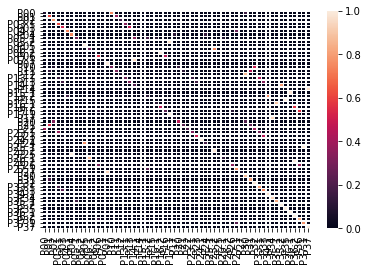

In [17]:

# perform rowwise normalisation on mapping_adj
prop_names = [myP.name for myP in network.memory.Ps]
vis_mappings(mapping_mat=mapping_adj,prop_names=prop_names)
error_val = mapping_error(mapping_mat=mapping_adj)
print(error_val)

In [16]:
baseline_mapping = np.ones((mapping_adj.shape))
baseline_mapping[:,:] = 1.0/baseline_mapping.shape[0]
print get_metrics(baseline_mapping)

(0.049999999999999836, 0.049999999999999906, 0.04999999999999987)


In [28]:
temp = []
for repetition in range(REPETITIONS):
    temp.append(simulated_data[repetition][0][-1])
temp = np.array(temp)
np.mean(temp)

0.6942717314621965

In [30]:
import pickle
f = open(parameters['results'],"wb")
pickle.dump(simulated_data,f)
f.close()

# Trials
## The kinds of tests that have been done and their results :

1. Keeping the object hanging (no predicate for object) means the RB is not created for the corresponding object. Weird.

1.1 Making the predicate a one-hot semantic perhaps? - Does not work

1.2 Making the predicate an empty semantic? - Does not work

1.3 Making the predicate a one-hot semantic that is orthogonal to other vectors? still noisy

2. Keeping the predicate hanging (no object for predicate)


3. Making the words 1 hot representations of their lexical properties, so here subject nouns, object nouns have a 1 hot rep, verbs, complemnetizer verbs, adjectives - Does MUCH BETTER. Promising results, but why are the mappings not perfect still?

3.1 Increase/decrease eta - nope - only makes existing connections stronger/weaker

3.2 gamma/delta/Hebbbias - (currently 0.3, .1, .5)

3.3 Don't ignore object semantics, and keep asDORA True - works better than 3.0

3.4 Try changing the predicate to the noun and keep the object empty - worked fine

4. Added loss metric. Now retry for all previous analysis - 100 runs

4.1 with one_to_one=True and max_norm=False, asDORA = True, ignore_object_sem = False, RMSE = 0.09

4.2 with one_to_one=True and max_norm=True, asDORA = True, ignore_objetct_sem=False, RMSE = 0.05 (def looks better)

4.3 try to use WordGCN and RMSE = .14

4.4 baseline_mapping RMSE = 0.103 (better than wordGCN :O )

4.5 setting embedding dimension = 5, and testing for simple word2vec model, RMSE = 0.12 (still worse than baseline)

5. Understanding object/predicate semantic usage :

5.3 strategic mapping has to be True for asDORA == False ( see do_mapping() )

5.4 Try with new semantic update - previous update was non linear max norm update. New update uses only link weight * parent act - RMSE = 

5.5 Try with new semantic update - added one hot semantic to empty object to distinguish it from other semantics, made sure ignore_object_semantics does not do what it should in the update_semantic code. 
RMSE = 0.098

5.6 Try with making predicate empty rather than object, RMSE = 0.108 :/ 

## Firing order similarity analysis : 

To make mapping more efficient, we have to consider firing order similarity in the mix. To make things easy, we have the firing order of the propositions in the driver. This is given by the ordering of the RBs themselves. 

To downweight/upweight the existing mapping connections, we need to consider the following :

5.1 We consider mappings in RBs and above. Therefore for every RB in the driver, we take a look at the POs that are connected to it in the driver, and the RB it maps to in the recipient, and its POs in the Recipient.

5.2 The mapping connection between RBs is upweighted if the indices of its POs match. Ex - RB1 maps to RB2 with weight w. PO11 and PO12 are the POs connected to RB1, and PO21 and PO22 are the POs connected to RB2. index(PO11), index(PO12), index(PO21), index(PO22) indicate where they appear in the RBs. Spearman Rank correlation between them should point to how similar they are. 

## Stuff to do : 

1. First, collect all mapping hypotheses in one place. This consists of all connections from Driver propositions to all recipient tokens of same type.

1.1 Don't break it now, but the Luce's choice algorithm is a bit weird. Gotta see why they use it. - instead of random threshold to retrieve analogs, use a fixed threshold = 0.1 currently

1.2 with threshold = 0.1, biasing proposition length as well, RMSE = 0.11 - looks bad. Got to find out a way to include RB firing order instead. 

1.3 Make sure P in parent is mapped to P in parent only. 

1.4 After taking out the one to one mapping constraint, mappings improve. - RMSE = 0.0853, set parent_bias = 0.5! 

1.5 setting parent_bias = 0.1 , 0.088 (not significant enough imo)

1.6 see how firing order similarity is affecting mapping coeff. Currently, mapping is in SSL, guided by a simple Hebbian learning rule that has coactivation as its basis. added correlations between activations to update_hyp. Correlations + one_to_one == True, RMSE = 0.067, one_to_one == False, RMSE = 0.077 (higher rmse :O )

1.7 Something to test out - parent and child modes need to be updated based on presence of parentRBs, not activations alons, nah? 

1.8 Run with larger prop number

1.9 Non recursive correlational mapping - 0.111

2.0 Firing by POs, mapping not reset after each run (god knows why that was being done in the first place)

2.1 Why does retrieval by bias_analog work so strangely? 

## Results - 

1.1 Collect RMSE over time, and plot the evolution
1.2 Comparison across word embedding strategies used
1.3 Record RB firing for proposition 0 in Ding stimuli style
